In [7]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [8]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge


 99% 52.0M/52.6M [00:04<00:00, 20.2MB/s]
100% 52.6M/52.6M [00:04<00:00, 13.3MB/s]


In [10]:
!unzip /content/jigsaw-toxic-comment-classification-challenge.zip

Archive:  /content/jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           


In [11]:
!unzip /content/train.csv.zip

Archive:  /content/train.csv.zip
  inflating: train.csv               


In [12]:
df = pd.read_csv('train.csv')

In [13]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [14]:
from tensorflow.keras.layers import TextVectorization

In [15]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [16]:
MAX_FEATURES = 200000
MAX_SEQUENCE_LENGTH = 100

In [17]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=MAX_SEQUENCE_LENGTH,
                               output_mode='int')

In [18]:
vectorizer.adapt(X.values)

In [19]:
vectorized_text = vectorizer(X.values)

In [20]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [21]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding, Input

In [23]:
model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,)))
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

In [24]:
f1 = tf.metrics.F1Score(average='macro', threshold=0.5)

In [25]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=['accuracy',f1])

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 100, 32)             │       6,400,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,433,638 (24.54 MB)

 Trainable params: 6,433,638 (24.54 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
history = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 123s 17ms/step - accuracy: 0.9520 - f1_score: 0.3053 - loss: 0.0866 - val_accuracy: 0.9939 - val_f1_score: 0.4148 - val_loss: 0.0436
Epoch 2/20
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 114s 16ms/step - accuracy: 0.9701 - f1_score: 0.4353 - loss: 0.0460 - val_accuracy: 0.9950 - val_f1_score: 0.4064 - val_loss: 0.0412
Epoch 3/20
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 142s 16ms/step - accuracy: 0.9915 - f1_score: 0.4471 - loss: 0.0412 - val_accuracy: 0.9942 - val_f1_score: 0.4892 - val_loss: 0.0370
Epoch 4/20
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 125s 18ms/step - accuracy: 0.9915 - f1_score: 0.4852 - loss: 0.0372 - val_accuracy: 0.9934 - val_f1_score: 0.5068 - val_loss: 0.0322
Epoch 5/20
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 131s 16ms/step - accuracy: 0.9658 - f1_score: 0.5084 - loss: 0.0327 - val_accuracy: 0.9938 - val_f1_score: 0.5352 - val_loss: 0.0286
Epoch 6/20
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 126s 18ms/step - accuracy: 0.9874 - f1_score: 0.5858 - loss: 0.0293 - val_accuracy:

In [28]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

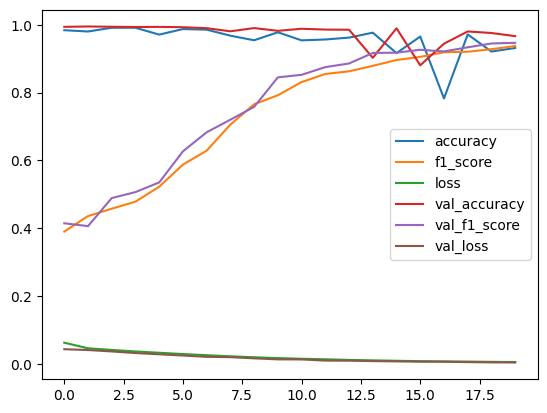

In [29]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [33]:
input_text = vectorizer('You freaking suck! I am going to hit you.')
input_text = tf.expand_dims(input_text,axis=-1)

In [34]:
res = model.predict(input_text)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


In [35]:
(res > 0.5).astype(int)

array([[0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
 

In [36]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [37]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [38]:
res.shape

(100, 6)

In [39]:
from tensorflow.keras.metrics import Precision, Recall

In [40]:
pre = Precision()
re = Recall()

In [41]:
for batch in test.as_numpy_iterator():
    X_true, y_true = batch
    yhat = model.predict(X_true)

    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

In [44]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}')

Precision: 0.9840189218521118, Recall:0.9762184619903564


In [43]:
model.save('toxicity.keras')
from google.colab import files
files.download('toxicity.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>